In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import hashlib

In [2]:
fin = open('data_train.csv')

featname = fin.readline().strip().split(',')
#Load the maximum index
maxID = {}
finID = open('maxID.txt')
for line in finID:
    i,id = line.strip().split('\t')
    maxID[featname[int(i)]] = int(id) + 1
maxID

{'adnw_id': 36,
 'adspot_id': 1106,
 'advertiser_id': 2166,
 'campaign_id': 11803,
 'category_id': 7204,
 'frequency': 10,
 'game_feed_id': 33598,
 'is_app': 2,
 'last_login_interval': 2349757,
 'last_paid_interval': 1053268596,
 'logged_at': 1,
 'media_id': 89765,
 'uid': 3691112,
 'user_type_id': 5}

In [4]:
train = pd.read_csv("data_train.csv")
train = train.fillna(0)

kinds={}
for name in featname:
    c = Counter(train[name])
    kinds[name] = len(c)
    print(name + " : " + str(len(c)))

logged_at : 1787195
advertiser_id : 136
campaign_id : 843
category_id : 14
adnw_id : 22
adspot_id : 52
uid : 1044427
frequency : 11
user_type_id : 4
media_id : 38535
is_app : 2
last_login_interval : 331665
last_paid_interval : 211786
game_feed_id : 1733
click : 2


In [15]:
ad_id = train["advertiser_id"]
category_id = train["category_id"]
adnw_id = train["adnw_id"]
adspot_id = train["adspot_id"]
frequency = train["frequency"]
user_type_id = train["user_type_id"]
id_list = [ad_id,category_id,adnw_id,adspot_id,user_type_id]

click = train["click"]

In [7]:
def onehot(ID_list):
    c = Counter(ID_list)
    #IDの種類数
    num = len(c)
    dic = {}
    i = 0
    for ID in c.keys():
        dic[ID] = i
        i += 1
    new_ID_list = []
    for ID in ID_list:
        new_ID_list.append(dic[ID])
    one_hot = np.eye(num)[new_ID_list]    
    return pd.DataFrame(one_hot)

In [9]:
df = []
for ids in id_list:
    df.append(onehot(ids))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
i = 0
for d in df:
    if(i==0):
        old_df = d
        i += 1
    else:
        old_df = pd.concat([old_df, d], axis=1)
        


In [12]:
X = np.matrix(old_df)

from sklearn.decomposition import PCA
decomposer = PCA(n_components=30, random_state=0)
decomposer.fit(X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
X_pca = decomposer.transform(X)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X_pca, click, test_size=0.2, random_state=0)

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, n_estimators=10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
y_test_pred = clf.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average='macro')

0.8201957237889967

In [31]:
test = pd.read_csv("data_test.csv")
test

ad_id = test["advertiser_id"]
category_id = test["category_id"]
adnw_id = test["adnw_id"]
adspot_id = test["adspot_id"]
frequency = test["frequency"]
user_type_id = test["user_type_id"]
id_list = [ad_id,category_id,adnw_id,adspot_id,user_type_id]


In [32]:
df = []
for ids in id_list:
    df.append(onehot(ids))

[0, 1, 2, 3, 4, 5, 3, 6, 7, 1, 8, 9, 10, 10, 2, 11, 12, 7, 13, 2, 1, 10, 3, 10, 3, 14, 15, 10, 1, 10, 16, 6, 17, 1, 17, 18, 13, 0, 19, 20, 21, 6, 22, 0, 21, 23, 19, 3, 24, 25, 11, 18, 15, 1, 1, 3, 13, 26, 24, 27, 18, 1, 3, 3, 2, 11, 28, 1, 24, 29, 30, 8, 31, 1, 1, 32, 18, 26, 33, 23, 23, 19, 7, 20, 34, 7, 35, 1, 36, 17, 1, 37, 26, 38, 39, 24, 40, 6, 8, 36, 1, 6, 16, 1, 11, 41, 17, 16, 7, 32, 3, 21, 11, 4, 29, 6, 26, 15, 3, 42, 1, 43, 1, 3, 8, 0, 36, 44, 23, 3, 2, 3, 1, 45, 46, 7, 7, 3, 12, 2, 1, 31, 47, 2, 1, 1, 24, 42, 42, 7, 27, 48, 16, 36, 11, 1, 1, 18, 49, 3, 18, 7, 34, 23, 3, 31, 30, 3, 22, 11, 3, 3, 21, 11, 43, 6, 22, 6, 8, 12, 1, 1, 31, 50, 0, 3, 3, 24, 8, 1, 51, 7, 4, 52, 3, 8, 3, 39, 7, 27, 7, 7, 1, 1, 11, 7, 53, 2, 31, 2, 11, 30, 53, 6, 6, 7, 19, 31, 11, 21, 27, 46, 31, 54, 34, 50, 4, 1, 7, 11, 31, 19, 19, 27, 1, 10, 1, 21, 44, 10, 9, 3, 11, 27, 29, 10, 10, 11, 3, 44, 55, 46, 9, 11, 3, 13, 1, 7, 3, 21, 11, 24, 3, 36, 0, 3, 3, 15, 17, 17, 17, 13, 3, 32, 10, 3, 1, 6, 7, 56, 1, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5

In [29]:
i = 0
for d in df:
    if(i==0):
        old_df = d
        i += 1
    else:
        old_df = pd.concat([old_df, d], axis=1)
    

In [30]:
val_X = np.matrix(old_df)

val_X_pca = decomposer.transform(val_X)

ValueError: operands could not be broadcast together with shapes (536940,226) (228,) 

In [22]:
y_val_pred = clf.predict_proba(val_X_pca)[:,1]


In [23]:
f = open('submit.dat', 'w') # 書き込みモードで開く
y_pred = list(map(str, y_val_pred))
for p in y_pred:
    f.writelines(p + "\n") # シーケンスが引数。
f.close()

In [27]:
len(y_val_pred),len(test)

(1816568, 536940)

時間に関する特徴設計
時間帯についてカテゴライズ

0 : night 1: day


In [41]:

hour = []
for data in logged_at:
    hour.append(int(data.split()[1][:2]))
max(hour)

time_zone = []
for h in hour:
    if(h < 6 or 18 < h):
        time_zone.append(0)
    else:
        time_zone.append(1)

time_zone = pd.Series(time_zone)


0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
1816538    1
1816539    1
1816540    1
1816541    1
1816542    1
1816543    1
1816544    1
1816545    1
1816546    1
1816547    1
1816548    1
1816549    1
1816550    1
1816551    1
1816552    1
1816553    1
1816554    1
1816555    1
1816556    1
1816557    1
1816558    1
1816559    1
1816560    1
1816561    1
1816562    1
1816563    1
1816564    1
1816565    1
1816566    1
1816567    1
Length: 1816568, dtype: int64

IDに関する特徴量

ID->登場頻度に変換

In [8]:
def to_freq(ID_list):
    #出現回数をカウント
    from collections import Counter
    c = Counter(ID_list)
    print(len(c))
    s = 0
    for num in c.values():
        s += num
    
    ID_freq_dic = {}
    for ID,num in c.items():
        ID_freq_dic[ID] = num / s
    
    lis = []
    for ID in ID_list:
        lis.append(ID_freq_dic[ID])
    return pd.Series(lis)



def onehot(ID_list):
    c = Counter(ID_list)
    #IDの種類数
    num = len(c)
    print(num)
    dic = {}
    i = 0
    for ID in c.keys():
        dic[ID] = i
        i += 1
    new_ID_list = []
    for ID in ID_list:
        new_ID_list.append(dic[ID])
    print(new_ID_list)
        
    one_hot = np.eye(num)[new_ID_list]    
    
    return pd.DataFrame(one_hot)
    
        

In [165]:
adv_one = onehot(adv_id)
user_freq = to_freq(uid)
is_app = pd.Series(is_app)



136


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [139]:
def hashing(ID_list,N):
    l=[]
    for ID in ID_list:
        h = hashlib.md5()
        h.update(str(ID).encode('utf-8'))
        ha = h.hexdigest()
        s = int(ha, 16)
        l.append(s%N)
    return pd.Series(l)

In [158]:

user_hash = hashing(uid, 10000)

In [166]:
#new_df = pd.concat([adv_freq, user_freq, is_app, time_zone], axis=1)
new_df = pd.concat([adv_one,user_hash, is_app, time_zone], axis=1)

X = np.matrix(new_df)

In [167]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, click, test_size=0.2, random_state=0)

In [168]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, n_estimators=10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [169]:
y_test_pred = clf.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average='macro')


0.6086907773468624

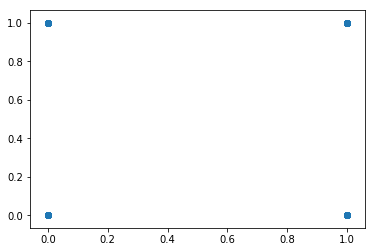

In [70]:
import matplotlib.pyplot as plt

plt.scatter(fre, y_train)
plt.show()


提出用

In [17]:
test = pd.read_csv('data_test.csv')

In [19]:
adv_id = test["advertiser_id"]
uid = test["uid"]
frequency = test["frequency"]
X_test = np.matrix(pd.concat([adv_id, uid,frequency], axis=1))

In [41]:
y_pred = clf.predict_proba(X_test)

array([[0.9, 0.1]])

In [42]:
y_pred = y_pred[:,0]

In [52]:
f = open('submit.dat', 'w') # 書き込みモードで開く
y_pred = list(map(str, y_pred))
for p in y_pred:
    f.writelines(p + "\n") # シーケンスが引数。
f.close()

In [58]:
def clickrate(ID_list, click_list):
    c = Counter(ID_list)
    
    clickrate = {}
    for ID, click in zip(ID_list, click_list):
        if(click == 1):
            if(not ID in clickrate.keys()):
                clickrate[ID] = 1
            else:
                clickrate[ID] += 1
            
        
    for ID, click in clickrate.items():
        clickrate[ID] = click/c[ID]
    
        
    return clickrate

In [62]:
clickrate(adv_id, click)

{1229: 0.08452908948604226,
 1235: 0.07537993920972644,
 1255: 0.15704387990762125,
 1264: 0.0737410071942446,
 1265: 0.0856269113149847,
 1268: 0.08231193073203644,
 1270: 0.11925507647432781,
 1278: 0.06051066806575726,
 1309: 0.1091307257132429,
 1312: 0.11900338760791171,
 1316: 0.09008664627930683,
 1349: 0.061452513966480445,
 1350: 0.11514975283512649,
 1354: 0.10960804717308359,
 1356: 0.06463089238067003,
 1357: 0.1405775075987842,
 1375: 0.10469667318982387,
 1383: 0.08968916883472546,
 1386: 0.10084033613445378,
 1403: 0.10187652675993782,
 1408: 0.10037934053107675,
 1409: 0.07751937984496124,
 1431: 0.1069199910853577,
 1436: 0.0791628753412193,
 1440: 0.0706713780918728,
 1445: 0.07244250970000947,
 1446: 0.04878048780487805,
 1461: 0.08719317527607683,
 1471: 0.11084964082239286,
 1472: 0.1047142261159783,
 1473: 0.09678510998307953,
 1480: 0.09436696250679225,
 1487: 0.0667016806722689,
 1489: 0.09070949849780448,
 1492: 0.09934771700953336,
 1513: 0.12956810631229235,


In [88]:
import hashlib
def hashing_vectorizer(ID_list, N):
    x = np.zeros(N, dtype = int)
    for ID in ID_list:
         h = hash(ID)
         x[ID % N] += 1
    
    return x

In [89]:
hashing_vectorizer(adv_id, 50)

array([  3439,   2585,   9809,  49372,  30836,  14437,  25496,   2941,
        15732, 270957,    125,  89321,  29544,   7437,  36130,  13955,
        47124,  63224,  41980,  70219, 134704,  35511,   7032,   8349,
       115113,   2044,      0,   1514,  30635,  22671, 173327,  54087,
          381,  62187,   7741,  60814,   7641,  87329,  17410,  23907,
         5920,   3148,  27982,    578,      0,  28834,   3073,   6261,
        18458,  45254])

In [81]:
hash(10000)

10000